In [82]:
# from scipy.ndimage.morphology import distance_transform_edt
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume
import edt
import struct
%matplotlib inline

## Demo of Seung lab's (thread-)parallelized edt function
I don't think it uses multiple cores, but it is at least 10x faster than scipy's distance_transform_edt() function and it can be used for multiple labels, see: https://github.com/seung-lab/euclidean-distance-transform-3d

In [2]:
labels = np.ones(shape=(687, 2560, 2160), dtype=np.uint8, order='F')

In [3]:
%%time
dt = edt.edt(
  labels, anisotropy=(6, 6, 30), 
  black_border=True, order='F',
  parallel=4 # number of threads, <= 0 sets to num cpu
) 

CPU times: user 4min 53s, sys: 12.4 s, total: 5min 5s
Wall time: 1min 17s


In [4]:
%%time
dt = edt.edt(
  labels, anisotropy=(6, 6, 30), 
  black_border=True, order='F',
  parallel=8 # number of threads, <= 0 sets to num cpu
) 

CPU times: user 6min 14s, sys: 33.2 s, total: 6min 48s
Wall time: 59.3 s


In [5]:
%%time
dt = edt.edt(
  labels, anisotropy=(6, 6, 30), 
  black_border=True, order='F',
  parallel=2 # number of threads, <= 0 sets to num cpu
) 

CPU times: user 4min 13s, sys: 8.9 s, total: 4min 22s
Wall time: 2min 11s


In [6]:
%%time
dt = edt.edt(
  labels, anisotropy=(6, 6, 30), 
  black_border=True, order='F',
  parallel=6 # number of threads, <= 0 sets to num cpu
) 

CPU times: user 5min 14s, sys: 16.2 s, total: 5min 30s
Wall time: 57.4 s


6 threads is fastest, at least for an array of all ones

## Raw-space PMA

In [7]:
cv_path = '/home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawatlas_an21'

In [8]:
vol = CloudVolume(f'file://{cv_path}',parallel=True)

In [9]:
pma_ann = np.transpose(vol[:][...,0],(2,1,0))

Downloading: 100%|██████████| 516/516 [00:05<00:00, 25.88it/s]



Downloading: 100%|██████████| 516/516 [00:05<00:00, 97.02it/s]


In [10]:
# convert to bool 
pma_ann_bool = pma_ann.astype('bool')

In [11]:
pma_ann_bool.dtype

dtype('bool')

In [12]:
pma_ann_bool.shape

(687, 2560, 2160)

In [14]:
pma_ann_bool.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

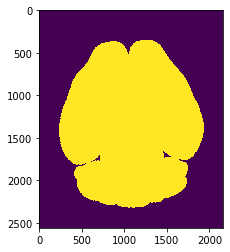

In [13]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(pma_ann_bool[200])

Good, looks like it worked.

In [15]:
%%time

anisotropy = (5,5,10) # resolution in microns in x,y,z according to edt docs
edt_pma_raw = edt.edt(
  pma_ann_bool,anisotropy=anisotropy, 
  black_border=True, order='C',
  parallel=6 # number of threads, <= 0 sets to num cpu
) 

CPU times: user 3min 12s, sys: 13.7 s, total: 3min 25s
Wall time: 34.9 s


In [16]:
#zero out near edges
edge_microns_to_erode = 60 # min distance from edge something will be allowed
edge_mask = edt_pma_raw < edge_microns_to_erode

In [17]:
eroded_ann = pma_ann.copy()

In [18]:
eroded_ann[edge_mask] = 0

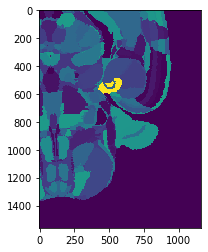

In [25]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(pma_ann[400,1000:15000,1000:15000],vmin=0,vmax=2000)

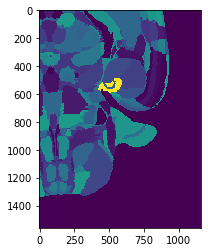

In [26]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(eroded_ann[400,1000:15000,1000:15000],vmin=0,vmax=2000)

It does look like it slightly eroded the edges, though a little hard to tell

In [84]:
#get ventricles - these are the values of ventricles in the annotation image (also the same as the look up file)
# ventricle_values = [108.0, 81.0, 116.0, 129.0, 145.0, 73.0]
ventricle_values = [108.0, 81.0, 129.0, 145.0, 73.0] # 116 has no voxels in PMA so not worth eroding near it
ventricular_microns_to_erode = 80 # min distance from ventricle something will be allowed


In [85]:
#zero out near ventricles
# in order to do this we need a volume in which the ventricle regions are set to 0 (the reference value for the edt)
# and all other values are set to non-zero.

# First set all zero values to 1 (outside the volume either from before or from erosion in previous step)
vann = np.copy(eroded_ann)
vann[vann==0.0] = 1 

In [88]:
# Now make a boolean mask finding where the ventricles are
vmask = np.isin(eroded_ann, ventricle_values)

In [89]:
# set values in vann where this mask applies to 0, the reference value for the edt
vann[vmask] = 0.0 #erode out nonventricular space adjacent to ventricles

In [92]:
# Make vann bool array so we can verify that the ventricle erosion worked
vann_bool = vann.astype('bool')

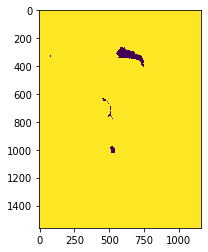

In [93]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(vann_bool[400,1000:15000,1000:15000],)

Looks good!

In [94]:
%%time
# now calculate the edt
anisotropy = (5,5,10) # resolution in microns in x,y,z according to edt docs
edt_ventricles_raw = edt.edt(
  vann_bool,anisotropy=anisotropy, 
  black_border=True, order='C',
  parallel=6 # number of threads, <= 0 sets to num cpu
) 

CPU times: user 5min 28s, sys: 9.69 s, total: 5min 38s
Wall time: 57.6 s


In [95]:
#zero out near ventricles on the volume which we have already edge-eroded
ventricle_mask = edt_ventricles_raw < ventricular_microns_to_erode

In [96]:
eroded_ann[ventricle_mask] = 0 

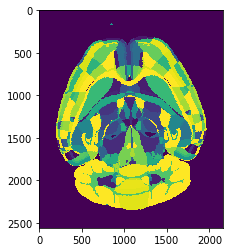

In [97]:
plt.imshow(pma_ann[262],vmin=0,vmax=1000)

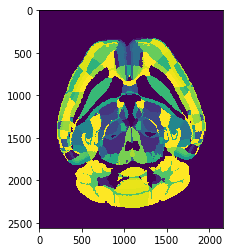

In [98]:
plt.imshow(eroded_ann[262],vmin=0,vmax=1000)

Can see that it worked. The ventricles are in the middle of the brain and are masked out and eroded in this volume. The edges also appear to be slightly eroded

## Apply the mask to the raw cell volume

In [27]:
cells_raw_path = "/jukebox/wang/Jess/lightsheet_output/201904_ymaze_cfos/processed/an21/clearmap_cluster_output/cells.npy"

In [28]:
converted_points = np.load(cells_raw_path)

In [51]:
converted_points

array([[ 570, 1516,   51],
       [ 571, 1491,   49],
       [ 572, 1509,   51],
       ...,
       [1638, 1131,  629],
       [1657, 1286,  624],
       [1741,  671,  683]])

In [29]:
len(converted_points)

243653

In [53]:
converted_points.shape

(243653, 3)

In [30]:
xyz = np.asarray([(int(xx[0]), int(xx[1]), int(xx[2])) for xx in converted_points]) #cells are counted in horizontal volumes

In [35]:
len(xyz)

243653

In [32]:
# read the cells into a volume the same size as the atlas
# init empty vol 
cell_map = np.zeros(pma_ann.shape).astype('uint8')

In [33]:
cell_map.shape

(687, 2560, 2160)

In [34]:
#fill volume
for x,y,z in xyz:
    try:
        cell_map[z,y,x] = 1 # no dilation
    except Exception as e:
        # Some cells will fall outside the volume - just how clearmap works
        print(e)

In [99]:
# Now apply the edge and ventricle mask
edt_mask = eroded_ann == 0
cell_map_eroded = cell_map.copy()
cell_map_eroded[edt_mask] = 0

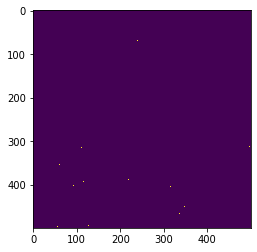

In [100]:
plt.imshow(cell_map[262,1000:1500,1000:1500])

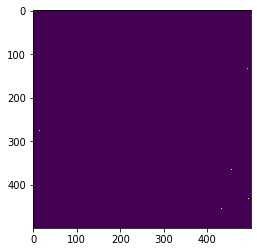

In [102]:
plt.imshow(cell_map_eroded[262,1000:1500,1000:1500])

Can see that it worked by the lack of cells near the bottom.
Best way to verify is to make precomputed layer and check in Neuroglancer though.

In [103]:
np.count_nonzero(cell_map)

243653

In [104]:
n_cells_eroded=np.count_nonzero(cell_map_eroded)
n_cells_eroded

163206

In [105]:
eroded_cell_coordinates = np.where(cell_map_eroded)

In [65]:
eroded_cell_coordinates

array([[  27,   29,   29, ...,  620,  623,  623],
       [1478, 1408, 1470, ...,  973,  974,  984],
       [ 871,  867,  867, ..., 1358, 1359, 1352]])

In [106]:
eroded_cell_coordinates = np.array(eroded_cell_coordinates)

In [107]:
eroded_cell_coordinates

array([[  27,   29,   29, ...,  620,  623,  623],
       [1478, 1408, 1470, ...,  973,  974,  984],
       [ 871,  867,  867, ..., 1358, 1359, 1352]])

In [108]:
zs_eroded=eroded_cell_coordinates[0]
ys_eroded=eroded_cell_coordinates[1]
xs_eroded=eroded_cell_coordinates[2]

In [109]:
xyz

array([[ 570, 1516,   51],
       [ 571, 1491,   49],
       [ 572, 1509,   51],
       ...,
       [1638, 1131,  629],
       [1657, 1286,  624],
       [1741,  671,  683]])

In [110]:
xyz_eroded = np.asarray([(int(xs_eroded[ii]), int(ys_eroded[ii]), int(zs_eroded[ii])) for ii in range(n_cells_eroded)]) #cells are counted in horizontal volumes

In [111]:
xyz_eroded

array([[ 871, 1478,   27],
       [ 867, 1408,   29],
       [ 867, 1470,   29],
       ...,
       [1358,  973,  620],
       [1359,  974,  623],
       [1352,  984,  623]])

In [112]:
len(xyz_eroded)

163206

In [113]:
np.random.shuffle(xyz_eroded)
xyz_eroded

array([[1013,  776,  131],
       [ 364, 1230,  495],
       [ 546,  821,  481],
       ...,
       [ 835,  721,  149],
       [1466, 1634,  344],
       [1756, 1416,  510]])

## Save eroded cell coordinates to precomputed format

In [114]:
filename = '/home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawcells_an21_annotations_edge_ventricle_erosion/spatial0/0_0_0'

In [115]:
coordinates = xyz_eroded # array like [[x1,y1,z1],[x2,y2,z2],...]
total_count = len(coordinates)
with open(filename,'wb') as outfile:
    buf = struct.pack('<Q',total_count)
    pt_buf = b''.join(struct.pack('<3f',x,y,z) for (x,y,z) in coordinates)
    buf += pt_buf
    id_buf = struct.pack('<%sQ' % len(coordinates), *range(len(coordinates)))
    buf += id_buf
    outfile.write(buf)
print(f"wrote {filename}")

wrote /home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawcells_an21_annotations_edge_ventricle_erosion/spatial0/0_0_0
